In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union
from sklearn.preprocessing import PowerTransformer


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# Funções de suporte




In [ ]:
def check_stationarity(series: pd.Series, seasonal_period: int = None, alpha: float = 0.05):
    """
    Check stationarity of a time series using the Augmented Dickey-Fuller test.
    Optionally handle seasonal differencing.

    Parameters:
        series (pd.Series): The input time series.
        seasonal_period (int, optional): Seasonal period (e.g., 12 for monthly).
        alpha (float): Significance level for ADF test.

    Returns:
        dict: {
            'adf_stat': float,
            'p_value': float,
            'stationary': bool,
            'diffs_needed': int,
            'seasonal_diffs_needed': int
        }
    """
    def is_stationary(y):
        result = adfuller(y, autolag='AIC')
        return result[0], result[1], result[1] < alpha

    y = series.dropna()
    if isinstance(series, pd.DataFrame):
        y = series.iloc[:, 0]

    # Check original series
    adf_stat, p_val, stationary = is_stationary(y)
    if stationary:
        return {
            'adf_stat': adf_stat,
            'p_value': p_val,
            'stationary': True,
            'diffs_needed': 0,
            'seasonal_diffs_needed': 0
        }

    # Seasonal differencing
    seasonal_diffs = 0
    if seasonal_period:
        for s in range(1, 3):  # try 1 or 2 seasonal diffs
            y_seasonal = y.diff(seasonal_period * s).dropna()
            adf_stat, p_val, stationary = is_stationary(y_seasonal)
            if stationary:
                return {
                    'adf_stat': adf_stat,
                    'p_value': p_val,
                    'stationary': True,
                    'diffs_needed': 0,
                    'seasonal_diffs_needed': s
                }

    # Try both seasonal + regular differencing
    if seasonal_period:
        y_combo = y.copy()
        for s in range(1, 3):
            for d in range(1, 3):
                y_combo = y.diff(seasonal_period * s).dropna().diff(d).dropna()
                adf_stat, p_val, stationary = is_stationary(y_combo)
                if stationary:
                    return {
                        'adf_stat': adf_stat,
                        'p_value': p_val,
                        'stationary': True,
                        'diffs_needed': d,
                        'seasonal_diffs_needed': s
                    }

    # Regular differencing
    diffs = 0
    y_diff = y.copy()
    while diffs < 3:
        y_diff = y_diff.diff().dropna()
        adf_stat, p_val, stationary = is_stationary(y_diff)
        diffs += 1
        if stationary:
            return {
                'adf_stat': adf_stat,
                'p_value': p_val,
                'stationary': True,
                'diffs_needed': diffs,
                'seasonal_diffs_needed': 0
            }


    # If nothing worked
    return {
        'adf_stat': adf_stat,
        'p_value': p_val,
        'stationary': False,
        'diffs_needed': diffs,
        'seasonal_diffs_needed': seasonal_diffs
    }


In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from multiprocessing import Pool, cpu_count
from typing import Union
from tqdm.notebook import tqdm

# Define your function to run in parallel
def fit_sarima(args):
    endog, order, d, D, s, seasonal = args
    try:
          model = SARIMAX(
              endog,
              order=(order[0], d, order[1]),
              seasonal_order=(order[2], D, order[3], s),
              simple_differencing=False
          ).fit(disp=False)
          return (order, model.aic)
    except:
        return None

def optimize_SARIMA_parallel(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    args_list = [(endog, order, d, D, s) for order in order_list]
    print(cpu_count())
    with Pool(cpu_count()) as pool:
        results = list(tqdm(pool.imap(fit_sarima, args_list), total=len(order_list)))

    # Filter out failed attempts (None)
    results = [res for res in results if res is not None]

    result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np

def check_white_noise(residuals: pd.Series, lags: int = 20, alpha: float = 0.05):
    """
    Check if residuals and squared residuals are white noise using the Ljung-Box test.

    Parameters:
        residuals (pd.Series): Residuals from a model.
        lags (int): Number of lags to test.
        alpha (float): Significance level.

    Returns:
        dict: {
            'residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            },
            'squared_residuals': {
                'p_values': pd.Series,
                'lags_failed': int
            }
        }
    """
    # Drop NaNs just in case
    residuals = pd.Series(residuals).dropna()
    squared_residuals = residuals**2

    # Ljung-Box on residuals
    lb_resid = acorr_ljungbox(residuals, lags=lags, return_df=True)
    resid_pvals = lb_resid['lb_pvalue']
    resid_failed = (resid_pvals < alpha).sum()

    # Ljung-Box on squared residuals
    lb_sq = acorr_ljungbox(squared_residuals, lags=lags, return_df=True)
    sq_pvals = lb_sq['lb_pvalue']
    sq_failed = (sq_pvals < alpha).sum()

    return {
        'residuals': {
            'p_values': resid_pvals,
            'lags_failed': resid_failed
        },
        'squared_residuals': {
            'p_values': sq_pvals,
            'lags_failed': sq_failed
        }
    }


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_model_mape(test_df, actual_col, pred_cols, title="Model Comparison (MAPE %)"):
    """
    Plots a bar chart of MAPE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    mape_scores = [mape(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, mape_scores, width=0.6,  edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('MAPE (%)')
    ax.set_ylim(0, max(mape_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(mape_scores):
        ax.text(i, val + 0.5, f"{val:.3f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, mape_scores))


In [ ]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_model_rmse(test_df, actual_col, pred_cols, title="Model Comparison (RMSE)"):
    """
    Plots a bar chart of RMSE for each prediction column.

    Parameters:
        test_df (pd.DataFrame): The dataframe containing actual and predicted values.
        actual_col (str): Column name with actual values.
        pred_cols (list of str): Column names with predicted values.
        title (str): Title of the plot.
    """
    rmse_scores = [rmse(test_df[actual_col], test_df[col]) for col in pred_cols]

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.bar(pred_cols, rmse_scores, width=0.6, color='lightcoral', edgecolor='black')
    ax.set_xlabel('Models')
    ax.set_ylabel('RMSE')
    ax.set_ylim(0, max(rmse_scores) * 1.2)
    ax.set_title(title)
    plt.xticks(rotation=35)

    for i, val in enumerate(rmse_scores):
        ax.text(i, val + max(rmse_scores) * 0.03, f"{val:.4f}", ha='center')

    plt.tight_layout()
    plt.show()

    return dict(zip(pred_cols, rmse_scores))


# SELEÇÃO DE MODELO


## Carregamento e visualização inicial da série

In [ ]:
df = pd.read_excel('/content/DadosCompeticao.xlsx', decimal=',')
serie_4 = df.iloc[:, 3]
serie_4.head()

,#4
0,0.000960
1,0.000000
2,0.007453
3,0.009529
4,0.012916


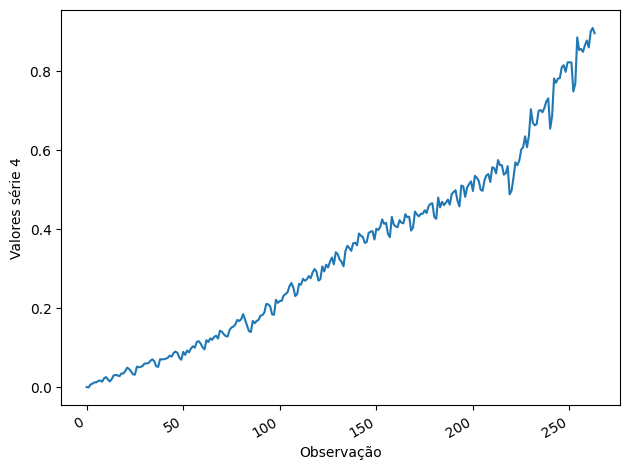

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_4)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores série 4')

fig.autofmt_xdate()
plt.tight_layout()


## Busca por sinais de sazonalidade

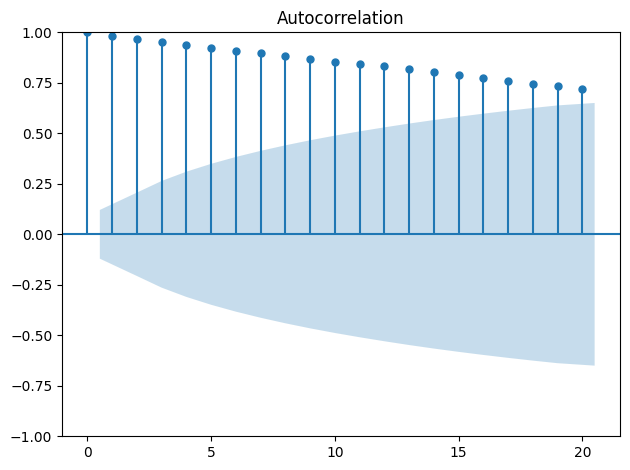

In [ ]:
plot_acf(serie_4, lags=20);
plt.tight_layout()

In [ ]:
advanced_decomposition = STL(serie_4,period=12).fit()

## Conjunto de treino

In [ ]:
test = pd.DataFrame()
test["Values"] = serie_4.iloc[-12:]
test['naive_seasonal'] = serie_4.iloc[-24:-12].values
test['naive_seasonal-A'] = serie_4.iloc[-24:-12].mean()

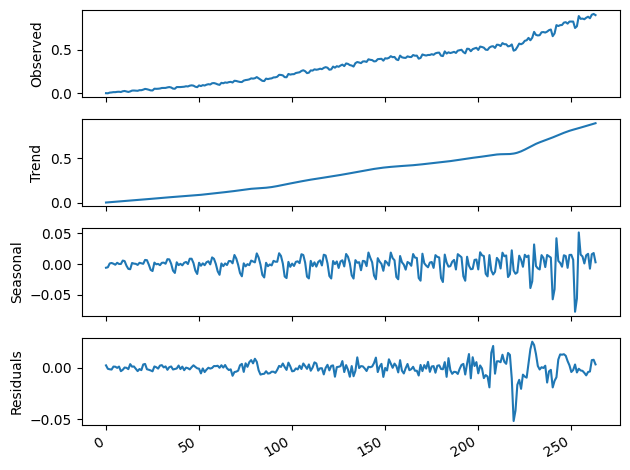

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

fig.autofmt_xdate()
plt.tight_layout()

## SARIMA

In [ ]:
check_stationarity(serie_4,seasonal_period=12)

{'adf_stat': -4.222409635959717,
 'p_value': 0.0006036526401328934,
 'stationary': True,
 'diffs_needed': 1,
 'seasonal_diffs_needed': 1}

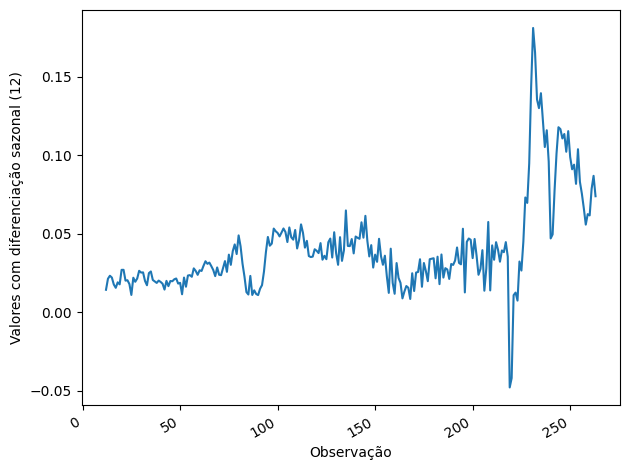

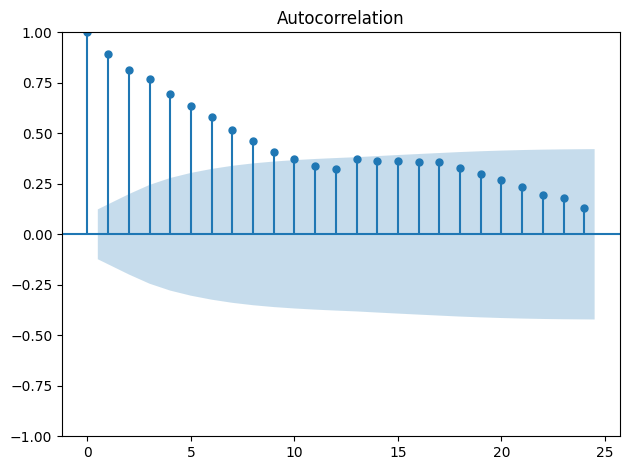

In [ ]:
seasonal_diff = serie_4.diff(12).dropna()
fig, ax = plt.subplots()

ax.plot(seasonal_diff)
ax.set_xlabel('Observação')
ax.set_ylabel('Valores com diferenciação sazonal (12)')

fig.autofmt_xdate()
plt.tight_layout()
plot_acf(seasonal_diff, lags=24);
plt.tight_layout()

### Treinamento

In [ ]:
train = serie_4[:-12]
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)


```
 from itertools import product

 ps = range(0, 6)
 qs = range(0, 6)
 Ps = range(0, 6)
 Qs = range(0, 6)

 SARIMA_order_list = list(product(ps, qs, Ps, Qs))

 train = serie_1[:-12]

 d = 1
 D = 0
 s = 12

 SARIMA_result_df = optimize_SARIMA_parallel(train, SARIMA_order_list, d, D, s)
 SARIMA_result_df
 */

```
Modelos selecionados:  \\

* ARIMA(11,2,6) | AIC = -1466.348396 \\
* SARIMA(2,1,0)(4,1,0,12) | AIC = -1463.250853


In [ ]:
# Apply Yeo-Johnson transformation
pt = PowerTransformer(method='yeo-johnson', standardize=False)
train_transformed = pd.Series(pt.fit_transform(train.values.reshape(-1, 1)).flatten(), index=train.index)

ARIMA_model = SARIMAX(train_transformed, order=(11,2,6), seasonal_order=(0,0,0,12), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)


SARIMA_model = SARIMAX(train_transformed, order=(2,1,0), seasonal_order=(4,1,0,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

In [ ]:
forecast_ARIMA = ARIMA_model_fit.forecast(steps=12)
test['ARIMA_pred'] = pt.inverse_transform(forecast_ARIMA.values.reshape(-1, 1)).flatten()
forecast_SARIMA = SARIMA_model_fit.forecast(steps=12)
test['SARIMA_pred'] = pt.inverse_transform(forecast_SARIMA.values.reshape(-1, 1)).flatten()


In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred
252,0.748894,0.654863,0.779211,0.766366,0.772059
253,0.768442,0.686651,0.779211,0.788930,0.770572
254,0.885650,0.781778,0.779211,0.857273,0.850646
255,0.853894,0.770867,0.779211,0.859345,0.835513
256,0.856635,0.781113,0.779211,0.868679,0.814605
257,0.849221,0.783046,0.779211,0.858899,0.844433
258,0.866224,0.810408,0.779211,0.897455,0.860607
259,0.877962,0.815484,0.779211,0.912344,0.868410
260,0.860344,0.798660,0.779211,0.897621,0.842539
261,0.901132,0.822537,0.779211,0.927548,0.885821


### Análise de resíduos

In [ ]:
check_white_noise(ARIMA_model_fit.resid, lags = 24)

{'residuals': {'p_values': 1     0.748578
  2     0.948747
  3     0.974166
  4     0.993583
  5     0.998681
  6     0.936783
  7     0.948219
  8     0.936146
  9     0.950067
  10    0.966601
  11    0.832093
  12    0.576075
  13    0.239627
  14    0.291612
  15    0.354281
  16    0.343460
  17    0.408484
  18    0.430077
  19    0.429857
  20    0.493393
  21    0.498612
  22    0.511806
  23    0.506383
  24    0.557551
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 0},
 'squared_residuals': {'p_values': 1     1.183461e-01
  2     6.103068e-02
  3     5.064729e-02
  4     9.903306e-02
  5     1.637191e-01
  6     2.387840e-01
  7     3.213092e-01
  8     2.406402e-01
  9     9.305137e-02
  10    2.294311e-02
  11    1.189148e-05
  12    4.477662e-08
  13    6.151552e-08
  14    1.369349e-07
  15    2.858090e-07
  16    5.688685e-07
  17    1.135757e-06
  18    2.156489e-06
  19    4.074107e-06
  20    7.201765e-06
  21    2.095461e-07
  22    1.444373e-07
  23    5.548315

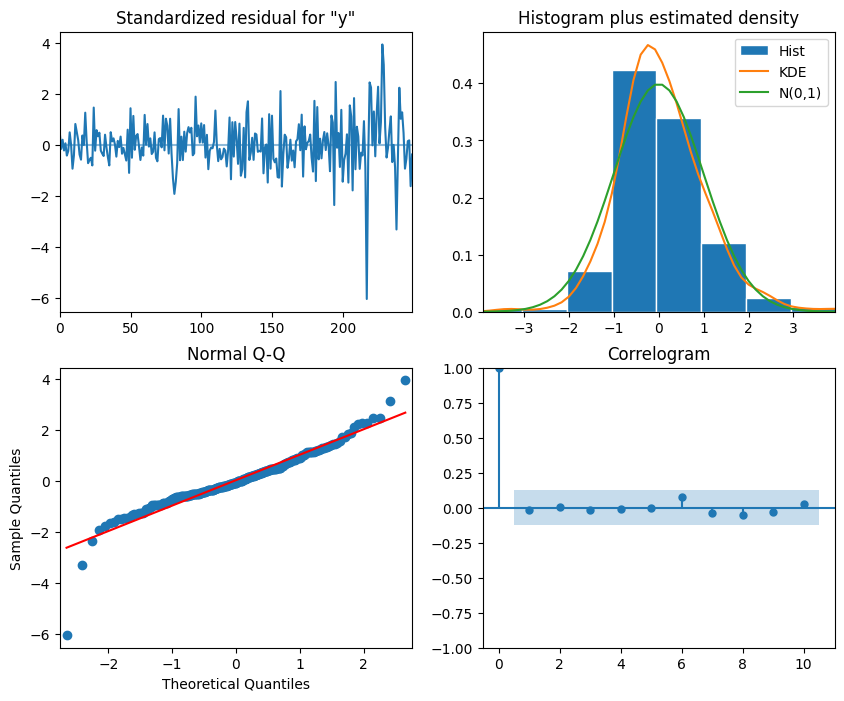

In [ ]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [ ]:
check_white_noise(SARIMA_model_fit.resid, lags = 12)

{'residuals': {'p_values': 1     0.205171
  2     0.405339
  3     0.603093
  4     0.752827
  5     0.833174
  6     0.907932
  7     0.909150
  8     0.924168
  9     0.957687
  10    0.636355
  11    0.665194
  12    0.629972
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 0},
 'squared_residuals': {'p_values': 1     2.707786e-04
  2     1.499192e-07
  3     1.409243e-07
  4     4.299146e-07
  5     1.348460e-06
  6     3.721484e-06
  7     9.107700e-06
  8     8.249873e-06
  9     1.007160e-05
  10    1.144191e-05
  11    5.367169e-06
  12    1.103278e-05
  Name: lb_pvalue, dtype: float64,
  'lags_failed': 12}}

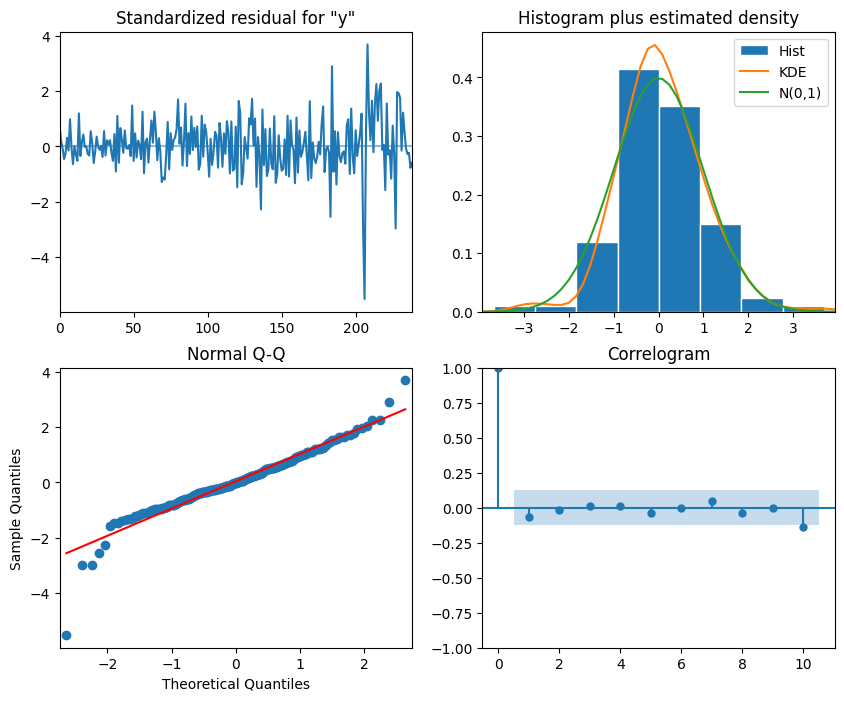

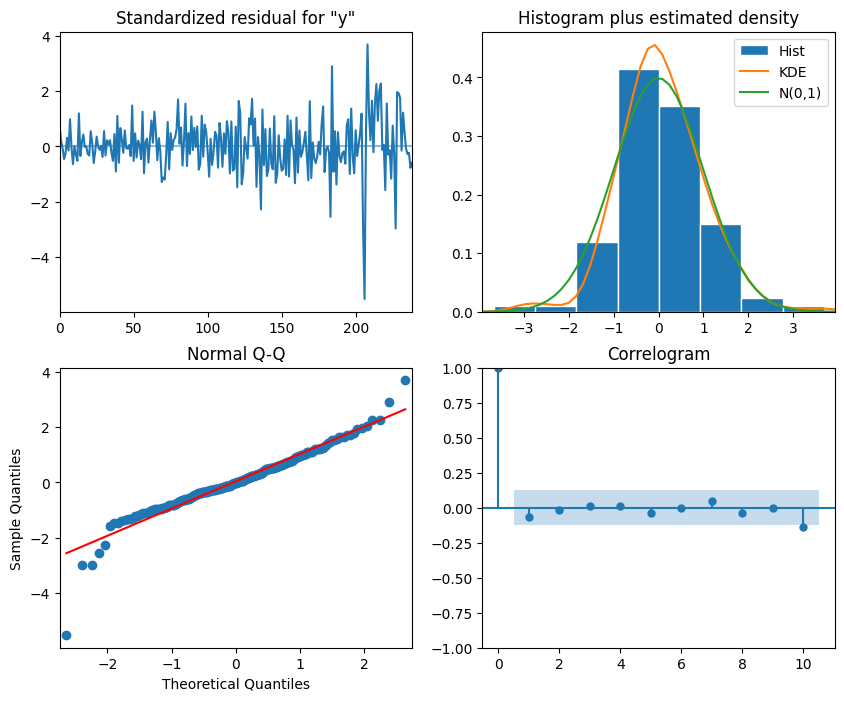

In [ ]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8))

## Holt-Winters

### Treinamento

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train = serie_4[:-12]
train_hw = train.diff(12).dropna()
ES = ExponentialSmoothing(train_hw, seasonal_periods=12)
ES_fit = ES.fit()
forecast_1 = ES_fit.forecast(12)
seasonal_base = train.iloc[-12:].values
ES_forecast = seasonal_base + forecast_1.values

ES3 = ExponentialSmoothing(train, trend='add' ,seasonal_periods=12)
ES3_fit = ES3.fit()

test["HW"] = ES_forecast
test["HW_P"] = ES3_fit.forecast(12).values
test


,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P
252,0.748894,0.654863,0.779211,0.766366,0.772059,0.748082,0.829988
253,0.768442,0.686651,0.779211,0.788930,0.770572,0.779871,0.835038
254,0.885650,0.781778,0.779211,0.857273,0.850646,0.874998,0.840089
255,0.853894,0.770867,0.779211,0.859345,0.835513,0.864087,0.845139
256,0.856635,0.781113,0.779211,0.868679,0.814605,0.874333,0.850189
257,0.849221,0.783046,0.779211,0.858899,0.844433,0.876265,0.855239
258,0.866224,0.810408,0.779211,0.897455,0.860607,0.903628,0.860289
259,0.877962,0.815484,0.779211,0.912344,0.868410,0.908704,0.865340
260,0.860344,0.798660,0.779211,0.897621,0.842539,0.891880,0.870390
261,0.901132,0.822537,0.779211,0.927548,0.885821,0.915756,0.875440


In [ ]:
print("Residuos 1:" + str(check_white_noise(ES_fit.resid)))

Residuos 1:{'residuals': {'p_values': 1     0.754366
2     0.195627
3     0.133203
4     0.193297
5     0.269498
6     0.349813
7     0.359928
8     0.386980
9     0.254133
10    0.242749
11    0.063714
12    0.000046
13    0.000001
14    0.000002
15    0.000003
16    0.000006
17    0.000003
18    0.000005
19    0.000009
20    0.000011
Name: lb_pvalue, dtype: float64, 'lags_failed': 9}, 'squared_residuals': {'p_values': 1     4.620735e-02
2     7.322323e-05
3     8.221794e-05
4     2.353920e-04
5     5.619904e-04
6     1.169861e-03
7     1.978925e-03
8     2.600137e-03
9     2.231574e-04
10    2.385548e-08
11    7.008401e-14
12    1.067214e-17
13    3.360406e-18
14    3.988299e-18
15    1.179043e-17
16    3.248317e-17
17    8.893945e-17
18    2.027141e-16
19    3.045273e-16
20    7.549028e-16
Name: lb_pvalue, dtype: float64, 'lags_failed': 20}}


In [ ]:
ES_fit.summary()

Dep. Variable:,#4,No. Observations:,240
Model:,ExponentialSmoothing,SSE,0.044
Optimized:,True,AIC,-2062.933
Trend:,None,BIC,-2055.972
Seasonal:,None,AICC,-2062.763
Seasonal Periods:,None,Date:,"Tue, 29 Apr 2025"
Box-Cox:,False,Time:,17:37:16
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7993841,alpha,True
initial_level,0.0157271,l.0,True


## Theta

In [ ]:
from statsmodels.tsa.forecasting.theta import ThetaModel

# Fit the Theta model
theta_model = ThetaModel(train.diff(12).dropna(),period=12)
theta_fit = theta_model.fit()

# Forecast future values
theta_forecast = theta_fit.forecast(steps=12)
seasonal_base = train.iloc[-12:].values
test["Theta"] = seasonal_base + theta_forecast.values
# Print results
print(theta_fit.summary())
print("Forecast:", theta_forecast)

                              ThetaModel Results                              
Dep. Variable:                     #4   No. Observations:                  240
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Tue, 29 Apr 2025   Deseas. Method:               Additive
Time:                        17:37:16   Period:                             12
Sample:                             0                                         
                                  240                                         
    Parameter Estimates     
            Parameters      
----------------------------
b0    0.00020612079015084895
alpha      0.804179699225796
----------------------------
Forecast: 252    0.089156
253    0.090202
254    0.094443
255    0.093565
256    0.093893
257    0.093890
258    0.093934
259    0.093968
260    0.093750
261    0.093676
262    0.094103
263    0.094483
Name: forecast, dtype: float64


## Visualização das predições


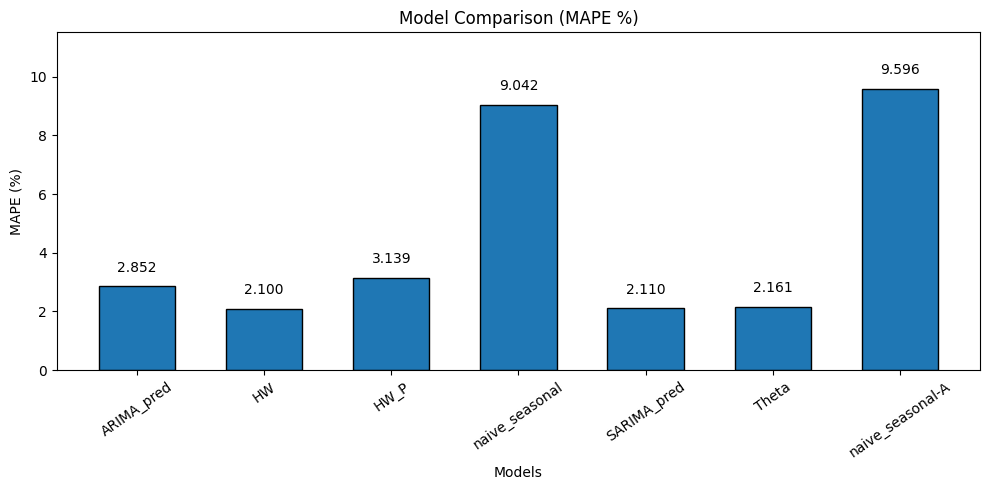

{'ARIMA_pred': 2.851940837921281,
 'HW': 2.1000453670017545,
 'HW_P': 3.139257820718432,
 'naive_seasonal': 9.042494191750842,
 'SARIMA_pred': 2.109657756111492,
 'Theta': 2.1606928834303774,
 'naive_seasonal-A': 9.595843696634514}

In [ ]:
test['naive_seasonal'] = serie_4.iloc[-24:-12].values
columns = ['ARIMA_pred','HW','HW_P','naive_seasonal','SARIMA_pred','Theta','naive_seasonal-A']
plot_model_mape(test,'Values',columns)

In [ ]:
test

,Values,naive_seasonal,naive_seasonal-A,ARIMA_pred,SARIMA_pred,HW,HW_P,Theta
252,0.748894,0.654863,0.779211,0.766366,0.772059,0.748082,0.829988,0.744019
253,0.768442,0.686651,0.779211,0.788930,0.770572,0.779871,0.835038,0.776853
254,0.885650,0.781778,0.779211,0.857273,0.850646,0.874998,0.840089,0.876221
255,0.853894,0.770867,0.779211,0.859345,0.835513,0.864087,0.845139,0.864432
256,0.856635,0.781113,0.779211,0.868679,0.814605,0.874333,0.850189,0.875006
257,0.849221,0.783046,0.779211,0.858899,0.844433,0.876265,0.855239,0.876936
258,0.866224,0.810408,0.779211,0.897455,0.860607,0.903628,0.860289,0.904342
259,0.877962,0.815484,0.779211,0.912344,0.868410,0.908704,0.865340,0.909453
260,0.860344,0.798660,0.779211,0.897621,0.842539,0.891880,0.870390,0.892410
261,0.901132,0.822537,0.779211,0.927548,0.885821,0.915756,0.875440,0.916212


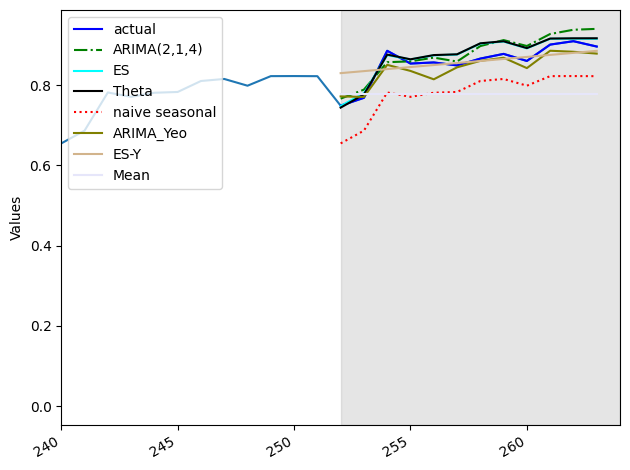

In [ ]:
fig, ax = plt.subplots()

ax.plot(serie_4)
ax.plot(test["Values"], 'b-', label='actual')
ax.plot(test['ARIMA_pred'], 'g-.', label='ARIMA(2,1,4)')
ax.plot(test['HW'], 'cyan', label='ES')
ax.plot(test['Theta'], 'black', label='Theta')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['SARIMA_pred'], 'olive', label='ARIMA_Yeo')
ax.plot(test['HW_P'], 'tan', label='ES-Y')
ax.plot(test['naive_seasonal-A'] , 'lavender', label='Mean')

ax.set_ylabel('Values')
ax.axvspan(252, 264, color='#808080', alpha=0.2)

ax.legend(loc=2)

ax.set_xlim(240, 264)

fig.autofmt_xdate()
plt.tight_layout()

## Métricas finais

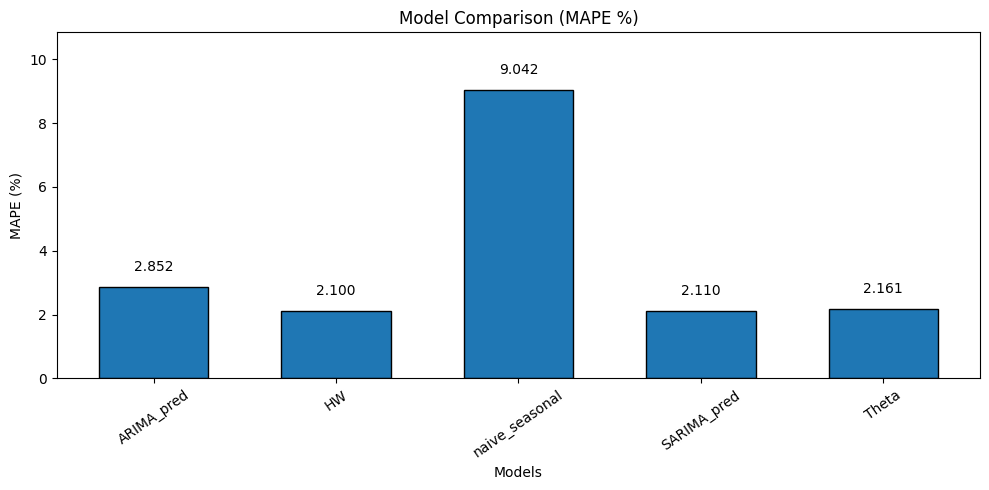

{'ARIMA_pred': 2.851940837921281,
 'HW': 2.1000453670017545,
 'naive_seasonal': 9.042494191750842,
 'SARIMA_pred': 2.109657756111492,
 'Theta': 2.1606928834303774}

In [ ]:
columns = ['ARIMA_pred','HW','naive_seasonal','SARIMA_pred','Theta']
plot_model_mape(test,'Values',columns)

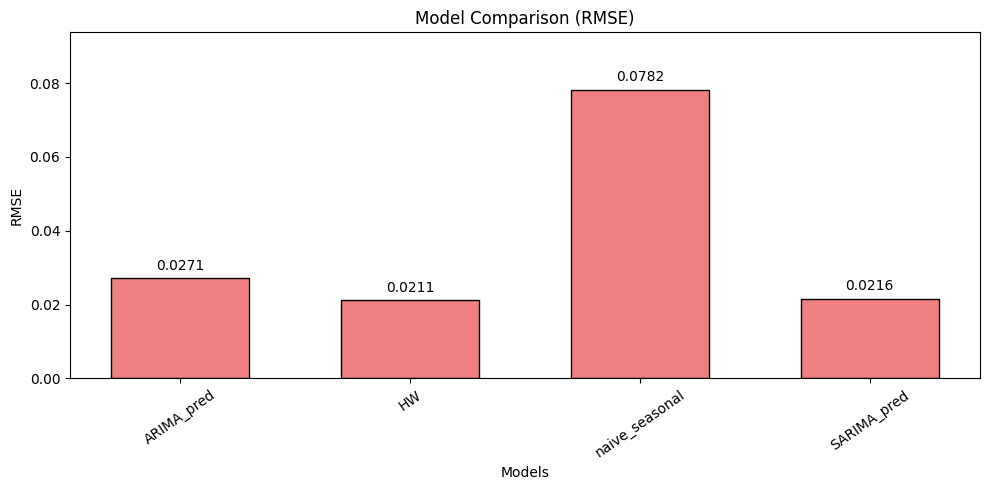

In [ ]:
columns_to_plot = ['ARIMA_pred','HW','naive_seasonal','SARIMA_pred']

rmse_results = plot_model_rmse(test, 'Values', columns_to_plot)

# Previsão para a série (próximos 12 meses)


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import PowerTransformer
import pandas as pd
import numpy as np

train_hw = serie_4.diff(12).dropna()
ES = ExponentialSmoothing(train_hw, seasonal_periods=12)
ES_fit = ES.fit()
forecast_1 = ES_fit.forecast(12)
seasonal_base = serie_4.iloc[-12:].values
ES_forecast = seasonal_base + forecast_1.values
ES_forecast


array([0.82493115, 0.84447945, 0.96168733, 0.92993139, 0.93267282,
       0.92525856, 0.94226182, 0.95399968, 0.93638129, 0.97716981,
       0.98565207, 0.9723499 ])

In [ ]:
# ----- Salvando previsões numeradas em um .txt -----
horizon = len(ES_forecast)  # ou 11, se já definido

with open("4.csv", "w") as f:
    for i, value in enumerate(ES_forecast, 1):
        f.write(f"{value:};\n")